In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from natsort import natsorted
from IPython.display import Image, display

import tensorflow as tf
from tensorflow.keras import layers, models, backend as K, optimizers, callbacks
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D,
    Permute, Reshape, Bidirectional, LSTM, Dense, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model, Sequence
from tensorflow.keras.models import load_model

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import pickle
import json
# Suppress TensorFlow INFO, WARNING, and ERROR messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# # Enable XLA
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [4]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import random
from IPython.display import clear_output
import gc
from PIL import Image

import tensorflow as tf

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Input, Lambda, Dense, Layer, Conv2D, Dropout, Reshape

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import layers, Model
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
# Limit TensorFlow to only use the first GPU
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')

# Verify the configuration
logical_gpus = tf.config.list_logical_devices('GPU')
print("Visible GPUs:", logical_gpus)

Visible GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


I0000 00:00:1733331933.813206   22227 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:00:08.0, compute capability: 8.0


In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Now limit TensorFlow to the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [8]:
# Set the seed for reproducibility
SEED = 570
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [9]:
# BATCH_SIZE = 24 # Original paper's BATCH_SIZE
BATCH_SIZE = 128
# EPOCHS = 300   
EPOCHS = 300

In [10]:
# Path to the folders
images_folder = 'KHATT-Dataset/images'
labels_folder = 'KHATT-Dataset/labels'

# List to store image paths and labels
data = []

# Iterate over files in images folder
for image_file in os.listdir(images_folder):
    if image_file.endswith(('.png', '.jpg', '.jpeg')):
        # Get image path
        image_path = os.path.join(images_folder, image_file)
        
        # Get corresponding label
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_folder, label_file)
        if os.path.exists(label_path):
            with open(label_path, 'r', encoding='windows-1256') as f:
            # with open(label_path, 'r', encoding='windows-1256') as f:
                label = f.read().strip()
        else:
            label = None
        
        # Add image path and label to data list
        data.append({'image_path': image_path, 'label': label})

# Create DataFrame from the data list
df = pd.DataFrame(data)

# Filter rows with missing labels
df = df.dropna(subset=['label'])

# Sort DataFrame by 'label' column
df = df.sort_values(by='label').reset_index(drop=True)

Label: " العلم قبسة من نور الله وقد خلق الله النور كشافاً مبصراً ، ولاداً للحرارة


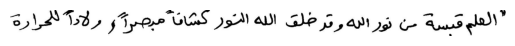

Label: "27" درجة و "30" دقيقة، بما يزيد على150 متراً، أي  هذه البادية مرتفعة في الغرب


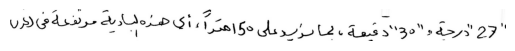

Label: "أعراب" و لم يقصد بها قوميّة، أي علم لهذا الجنس المعروف، الذي يشمل


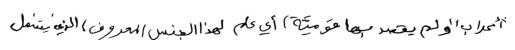

Label: "إسطبل عنتر"، كلتا تعرف به في الزمن


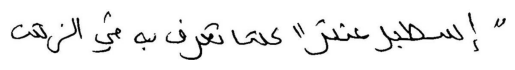

Label: "إيليا الحاوى" فقال :- أن هذه الألفاظ قد تكون عامية، مشبعة


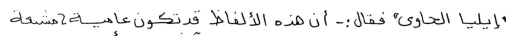

In [11]:
def plot_sample(df, index):
    img_path = df.iloc[index]['image_path']
    label = df.iloc[index]['label']
    img = Image.open(img_path) # Convert to grayscale
    plt.imshow(img, cmap='gray')
    print(f"Label: {label}")
    plt.axis('off')
    plt.show()

# Plot first 3 samples
for i in range(5):
    plot_sample(df, i)

In [12]:
# 1. Identifying Unique Characters in the Dataset
characters_in_data = set(char for label in df['label'] for char in label)
characters_in_data = sorted(list(characters_in_data))

print(f"Unique characters in the dataset: {characters_in_data}")
print(f"Total unique characters: {len(characters_in_data)}")

# 2. Maximum Length of Any Line in the Dataset
max_length = max(len(label) for label in df['label'])
print(f"The maximum line length is {max_length} characters.")

Unique characters in the dataset: [' ', '!', '"', '#', '%', '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', 'I', '[', '\\', ']', '_', 'x', '\xa0', '×', '،', '؛', '؟', 'ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ـ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي', 'ً', 'ٌ', 'ٍ', 'َ', 'ُ', 'ِ', 'ّ', 'ْ', '–', '‘']
Total unique characters: 86
The maximum line length is 132 characters.


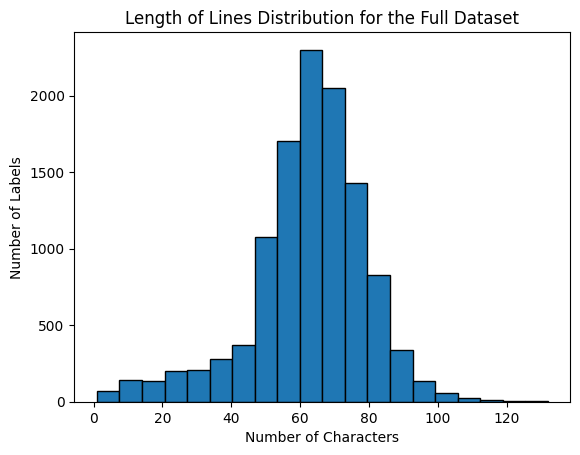

Maximum label length in the full dataset: 132


In [13]:
# Calculate the lengths of labels in the full dataset
full_label_lengths = [len(label) for label in df['label']]

# Plotting the distribution of label lengths
plt.figure()
plt.title('Length of Lines Distribution for the Full Dataset')
plt.xlabel('Number of Characters')
plt.ylabel('Number of Labels')
plt.hist(full_label_lengths, bins=20, edgecolor='black')  # Adjust bins as needed
plt.savefig(f'OCR_distribution_of_label_lengths_{SEED}.png')
plt.show()
plt.close()

# Exploring the longest label length
max_label_length_full = max(full_label_lengths)
print(f'Maximum label length in the full dataset: {max_label_length_full}')

In [14]:
# # Display all rows and columns
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# # Prevent truncation of column content
# pd.set_option('display.max_colwidth', None)

# # Optional: Prevent truncation of DataFrame width
# pd.set_option('display.width', None)

In [15]:
# Define the character set without the blank token
characters = characters_in_data

# Define the blank token
blank_token = '~'

# Append the blank token to the character list
characters.append(blank_token)

# Total number of classes including the blank token
num_classes = len(characters)  # Should be 49

# Create mappings
char_to_num = {char: idx for idx, char in enumerate(characters)}  # 'ا':0, ..., '-':48
num_to_char = {idx: char for char, idx in char_to_num.items()}

# Verify the mappings
print(f"Number of classes (including blank): {num_classes}")
print(f"Character to Number Mapping: {char_to_num}")

# # Flip label
# df['label'] = df['label'][::-1]

# Define the label encoding function
def encode_label(label):
    """
    Encodes a text label into a sequence of integers, excluding the blank token.
    """
    # Reverse the label if images are flipped
    label = label[::-1]
    return [char_to_num[char] for char in label if char in char_to_num and char != blank_token]

# Apply encoding to the DataFrame
df['encoded_label'] = df['label'].apply(encode_label)

# Update label lengths
df['label_length'] = df['encoded_label'].apply(len)

# Define input_length and max_label_length based on your model's architecture
input_length = 832  # As per your requirement
max_label_length = input_length - 2  # CTC requirement: input_length >= label_length + 2

# Define the label padding function
def pad_label(label, max_length=max_label_length):
    """
    Pads or truncates the label to `max_length` using the blank token index.
    """
    blank_index = char_to_num[blank_token]  # 48
    if len(label) > max_length:
        return label[:max_length]
    else:
        return label + [blank_index] * (max_length - len(label))

# Apply padding to the encoded labels
df['padded_label'] = df['encoded_label'].apply(pad_label)

# print(f"These are the number of NaNs: {df.isna().sum().sum()}")
# print(f"These are the number of nulls: {df.isnull().sum().sum()}")

# # Remove samples with label_length == 0
# df = df[df['label_length'] > 0].reset_index(drop=True)

# Verify padding (optional)
print(df[['label', 'encoded_label', 'padded_label', 'label_length']].head())

Number of classes (including blank): 87
Character to Number Mapping: {' ': 0, '!': 1, '"': 2, '#': 3, '%': 4, '(': 5, ')': 6, '*': 7, '+': 8, ',': 9, '-': 10, '.': 11, '/': 12, '0': 13, '1': 14, '2': 15, '3': 16, '4': 17, '5': 18, '6': 19, '7': 20, '8': 21, '9': 22, ':': 23, ';': 24, '=': 25, '>': 26, '?': 27, 'I': 28, '[': 29, '\\': 30, ']': 31, '_': 32, 'x': 33, '\xa0': 34, '×': 35, '،': 36, '؛': 37, '؟': 38, 'ء': 39, 'آ': 40, 'أ': 41, 'ؤ': 42, 'إ': 43, 'ئ': 44, 'ا': 45, 'ب': 46, 'ة': 47, 'ت': 48, 'ث': 49, 'ج': 50, 'ح': 51, 'خ': 52, 'د': 53, 'ذ': 54, 'ر': 55, 'ز': 56, 'س': 57, 'ش': 58, 'ص': 59, 'ض': 60, 'ط': 61, 'ظ': 62, 'ع': 63, 'غ': 64, 'ـ': 65, 'ف': 66, 'ق': 67, 'ك': 68, 'ل': 69, 'م': 70, 'ن': 71, 'ه': 72, 'و': 73, 'ى': 74, 'ي': 75, 'ً': 76, 'ٌ': 77, 'ٍ': 78, 'َ': 79, 'ُ': 80, 'ِ': 81, 'ّ': 82, 'ْ': 83, '–': 84, '‘': 85, '~': 86}
                                               label  \
0  " العلم قبسة من نور الله وقد خلق الله النور كش...   
1  "27" درجة و "30" دقيقة، بما يزيد على15

In [16]:
# Stratifying directly on continuous variables (like label lengths)
# isn't supported by train_test_split.
# Therefore, we'll bin the label lengths into discrete categories.

# Define bin size based on label length distribution
bin_size = 10  # Adjust bin size based on label length variability
max_label_length = df['label_length'].max() # CTC requirement: input_length >= label_length + 2
bins = list(range(0, max_label_length + bin_size, bin_size))

# Create a new column 'length_bin' for stratification
df['length_bin'] = pd.cut(df['label_length'], bins=bins, labels=False, include_lowest=True)

# Display the distribution of label lengths and bins
print("Label Length Distribution:")
print(df['label_length'].describe())

print("\nLabel Length Bins:")
print(df['length_bin'].value_counts())

Label Length Distribution:
count    11375.000000
mean        62.722462
std         16.990980
min          1.000000
25%         55.000000
50%         64.000000
75%         73.000000
max        132.000000
Name: label_length, dtype: float64

Label Length Bins:
length_bin
6     3154
5     2718
7     2425
8      902
4      798
3      367
2      319
9      251
1      208
0      141
10      68
11      15
12       6
13       3
Name: count, dtype: int64


In [17]:
# Combine bins with very few samples (e.g., bins 8–10)
# into a single bin to ensure adequate representation during stratification.

# Merge sparse bins into a single category
df['length_bin'] = df['length_bin'].apply(lambda x: x if x < 8 else 8)

# Check new bin distribution
print("\nUpdated Label Length Bins:")
print(df['length_bin'].value_counts())


Updated Label Length Bins:
length_bin
6    3154
5    2718
7    2425
8    1245
4     798
3     367
2     319
1     208
0     141
Name: count, dtype: int64


In [18]:
# # First Split: 80% Train and 20% Temp
# train_df, temp_df = train_test_split(
#     df,
#     test_size=0.2,
#     random_state=SEED
# )

# # Second Split: 10% Validation and 10% Test
# val_df, test_df = train_test_split(
#     temp_df,
#     test_size=0.5,
#     random_state=SEED
# )

In [19]:
# First Split: 80% Train and 20% Temp
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['length_bin'],  # Use length_bin for stratification
    random_state=SEED
)

# Second Split: 10% Validation and 10% Test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['length_bin'],  # Use length_bin for stratification
    random_state=SEED
)

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9100 entries, 4653 to 10743
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_path     9100 non-null   object
 1   label          9100 non-null   object
 2   encoded_label  9100 non-null   object
 3   label_length   9100 non-null   int64 
 4   padded_label   9100 non-null   object
 5   length_bin     9100 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 497.7+ KB


In [21]:
# Identify and inspect samples with label_length = 0
empty_labels_train = train_df[train_df['label_length'] == 0]
empty_labels_val = val_df[val_df['label_length'] == 0]
empty_labels_test = test_df[test_df['label_length'] == 0]

print(f"Empty labels in Training set: {empty_labels_train.shape[0]}")
print(f"Empty labels in Validation set: {empty_labels_val.shape[0]}")
print(f"Empty labels in Testing set: {empty_labels_test.shape[0]}")

# Inspect the problematic labels
print("\nProblematic Training Labels:")
print(empty_labels_train[['label', 'encoded_label']])

print("\nProblematic Testing Labels:")
print(empty_labels_test[['label', 'encoded_label']])

Empty labels in Training set: 0
Empty labels in Validation set: 0
Empty labels in Testing set: 0

Problematic Training Labels:
Empty DataFrame
Columns: [label, encoded_label]
Index: []

Problematic Testing Labels:
Empty DataFrame
Columns: [label, encoded_label]
Index: []


In [22]:
# Remove samples with label_length = 0
train_df = train_df[train_df['label_length'] > 0].reset_index(drop=True)
val_df = val_df[val_df['label_length'] > 0].reset_index(drop=True)
test_df = test_df[test_df['label_length'] > 0].reset_index(drop=True)

# Verify removal
empty_labels_train_after = train_df[train_df['label_length'] == 0]
empty_labels_val_after = val_df[val_df['label_length'] == 0]
empty_labels_test_after = test_df[test_df['label_length'] == 0]

print(f"Empty labels in Training set after removal: {empty_labels_train_after.shape[0]}")
print(f"Empty labels in Validation set after removal: {empty_labels_val_after.shape[0]}")
print(f"Empty labels in Testing set after removal: {empty_labels_test_after.shape[0]}")

Empty labels in Training set after removal: 0
Empty labels in Validation set after removal: 0
Empty labels in Testing set after removal: 0


In [23]:
# Extract all unique characters from the dataset
all_chars = set(''.join(df['label'].tolist()))
mapped_chars = set(char_to_num.keys())
unmapped_chars = all_chars - mapped_chars

print(f"Number of unique characters in dataset: {len(all_chars)}")
print(f"Number of mapped characters: {len(mapped_chars)}")
print(f"Number of unmapped characters: {len(unmapped_chars)}")
print(f"Unmapped characters: {unmapped_chars}")

Number of unique characters in dataset: 86
Number of mapped characters: 87
Number of unmapped characters: 0
Unmapped characters: set()


In [24]:
# Display the number of samples in each split
print(f"Total samples: {len(df)}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

Total samples: 11375
Training samples: 9100
Validation samples: 1137
Testing samples: 1138


In [25]:
# Verify bin distribution across splits
print("\nTrain Bin Distribution:")
print(train_df['length_bin'].value_counts(normalize=True))
print("\nValidation Bin Distribution:")
print(val_df['length_bin'].value_counts(normalize=True))
print("\nTest Bin Distribution:")
print(test_df['length_bin'].value_counts(normalize=True))


Train Bin Distribution:
length_bin
6    0.277253
5    0.239011
7    0.213187
8    0.109451
4    0.070110
3    0.032308
2    0.028022
1    0.018242
0    0.012418
Name: proportion, dtype: float64

Validation Bin Distribution:
length_bin
6    0.277045
5    0.238347
7    0.212841
8    0.109938
4    0.070361
3    0.032542
2    0.028144
1    0.018470
0    0.012313
Name: proportion, dtype: float64

Test Bin Distribution:
length_bin
6    0.277680
5    0.239016
7    0.213533
8    0.108963
4    0.070299
3    0.031634
2    0.028120
1    0.018453
0    0.012302
Name: proportion, dtype: float64


In [26]:
# Drop the 'length_bin' column as it's no longer needed
train_df = train_df.drop(columns=['length_bin'])
val_df = val_df.drop(columns=['length_bin'])
test_df = test_df.drop(columns=['length_bin'])

In [27]:
# Function to display label length statistics
def display_split_stats(split_name, split_df):
    print(f"\n{split_name} Set Label Length Statistics:")
    print(split_df['label_length'].describe())
    print(f"Label Length Distribution:\n{split_df['label_length'].value_counts().sort_index()}")

# Display statistics for each split
display_split_stats("Training", train_df)
display_split_stats("Validation", val_df)
display_split_stats("Testing", test_df)


Training Set Label Length Statistics:
count    9100.000000
mean       62.733187
std        17.066146
min         1.000000
25%        55.000000
50%        64.000000
75%        73.000000
max       132.000000
Name: label_length, dtype: float64
Label Length Distribution:
label_length
1       1
3       6
4       7
5      17
6       9
       ..
125     2
127     1
129     1
131     2
132     1
Name: count, Length: 122, dtype: int64

Validation Set Label Length Statistics:
count    1137.000000
mean       62.637643
std        16.773625
min         4.000000
25%        55.000000
50%        64.000000
75%        74.000000
max       125.000000
Name: label_length, dtype: float64
Label Length Distribution:
label_length
4      1
5      1
8      4
9      1
10     7
      ..
98     2
100    2
108    1
109    2
125    1
Name: count, Length: 96, dtype: int64

Testing Set Label Length Statistics:
count    1138.000000
mean       62.721441
std        16.614431
min         3.000000
25%        55.000000
50%  

In [28]:
def residual_block(x, filters, kernel_size=3, stride=1, padding='same', repeat=1, block_name="residual_block"):
    """
    Build a residual block repeated as specified.
    
    Args:
        x: Input tensor.
        filters: Number of filters for Conv2D layers.
        kernel_size: Kernel size for Conv2D layers.
        stride: Stride for the first Conv2D layer in the block.
        padding: Padding type for Conv2D layers ('same' ensures spatial dimensions are preserved).
        repeat: Number of times to repeat the residual block.
        block_name: Unique name for the block.

    Returns:
        Output tensor after applying the residual block.
    """
    for i in range(repeat):
        shortcut = x

        # Adjust the shortcut dimensions if necessary
        if x.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same',
                                      name=f'{block_name}_shortcut_{i+1}')(shortcut)
            shortcut = layers.BatchNormalization(name=f'{block_name}_shortcut_bn_{i+1}')(shortcut)
        
        # First convolutional layer
        x = layers.Conv2D(filters, kernel_size, strides=stride, padding=padding, activation='relu',
                          name=f'{block_name}_conv1_{i+1}')(x)
        x = layers.BatchNormalization(name=f'{block_name}_bn1_{i+1}')(x)

        # Second convolutional layer
        x = layers.Conv2D(filters, kernel_size, strides=1, padding=padding,
                          name=f'{block_name}_conv2_{i+1}')(x)
        x = layers.BatchNormalization(name=f'{block_name}_bn2_{i+1}')(x)

        # Add shortcut and apply activation
        x = layers.Add(name=f'{block_name}_add_{i+1}')([x, shortcut])
        # x = layers.Add(name=f'{block_name}_add_{i+1}')([x, shortcut])
        x = layers.ReLU(name=f'{block_name}_relu_{i+1}')(x)
    return x

In [29]:
def build_resnet32(input_shape):
    """
    Build the 32-layer ResNet model as described in the paper.
    
    Args:
        input_shape: Shape of the input tensor.

    Returns:
        The ResNet32 model.
    """
    inputs = Input(shape=input_shape, name='input_layer')

    # Conv1
    x = layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv1_1')(inputs)
    x = layers.BatchNormalization(name='conv1_bn1')(x)
    x = layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv1_2')(x)
    x = layers.BatchNormalization(name='conv1_bn2')(x)

    # Conv2
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = residual_block(x, 64, kernel_size=3, repeat=1, block_name="conv2_block")  # Residual block ×1
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv2')(x)
    x = layers.BatchNormalization(name='conv2_bn')(x)

    # Conv3
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = residual_block(x, 128, kernel_size=3, repeat=2, block_name="conv3_block")  # Residual block ×2
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv3')(x)
    x = layers.BatchNormalization(name='conv3_bn')(x)

    # Conv4
    x = layers.MaxPooling2D((2, 2), strides=(1, 2), padding='valid', name='pool3')(x)
    x = residual_block(x, 256, kernel_size=3, repeat=5, block_name="conv4_block")  # Residual block ×5
    x = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv4')(x)
    x = layers.BatchNormalization(name='conv4_bn')(x)

    # Conv5
    x = residual_block(x, 256, kernel_size=3, repeat=3, block_name="conv5_block")  # Residual block ×3
    x = layers.Conv2D(256, (2, 2), strides=(1, 2), padding='valid', activation='relu', name='conv5_1')(x)
    x = layers.BatchNormalization(name='conv5_1_bn')(x)
    x = layers.Conv2D(256, (2, 2), strides=(1, 1), padding='valid', activation='relu', name='conv5_2')(x)
    x = layers.BatchNormalization(name='conv5_2_bn')(x)

    # Model
    model = Model(inputs, x, name='ResNet32')
    return model

In [30]:
## WORKS PERFECTLYYY FINEEEE

@tf.keras.utils.register_keras_serializable()
class CTCLossLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(CTCLossLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        labels, y_pred, input_length, label_length = inputs
        # Compute CTC loss using TensorFlow's built-in function
        loss = K.ctc_batch_cost(labels, y_pred, input_length, label_length)
        self.add_loss(loss)  # Add the loss to the model
        return y_pred  # Return predictions for downstream layers if any
    
    def get_config(self):
        config = super(CTCLossLayer, self).get_config()
        return config

# # Dummy loss for compilation
# @tf.keras.utils.register_keras_serializable()
# def ctc_dummy_loss(y_true, y_pred):
#     return 0.0

In [31]:
### WORKS PERFECTLY FINEEEE

def build_ocr_model_with_ctc(input_shape, num_classes):
    resnet = build_resnet32(input_shape)
    inputs = Input(shape=input_shape, name='image_input')
    labels = Input(name='label_input', shape=(None,), dtype='int32')
    input_lengths = Input(name='input_length', shape=(1,), dtype='int32')
    label_lengths = Input(name='label_length', shape=(1,), dtype='int32')

    # Feature extraction with ResNet
    x = resnet(inputs)

    # # Dropout after ResNet
    # x = layers.Dropout(rate=0.2, name="dropout_resnet")(x)
    x = layers.SpatialDropout2D(rate=0.2, name="dropout_resnet")(x)

    x = layers.Reshape((-1, x.shape[-1]))(x)  # Reshape for LSTM layers

    # BiLSTM layers
    for _ in range(3):  # Add 3 BiLSTM layers
        x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x)
        # x = layers.Bidirectional(layers.LSTM(512, return_sequences=True, dropout=0.2))(x)

    # Dropout After BiLSTM Layers
    x = layers.Dropout(rate=0.2, name="dropout_bilstm")(x)

    # Fully connected layer for logits
    # logits = layers.Dense(num_classes + 1, activation="linear", name='logits')(x)
    logits = layers.Dense(num_classes + 1, activation="softmax", name='logits')(x)

    # CTC Loss Layer
    loss = CTCLossLayer(name="ctc_loss")([labels, logits, input_lengths, label_lengths])

    # Define the final model using a dictionary of inputs
    inputs_dict = {
        'image_input': inputs,
        'label_input': labels,
        'input_length': input_lengths,
        'label_length': label_lengths
    }
    model = Model(inputs=inputs_dict, outputs=loss, name='OCR_Model')
    return model

In [32]:
desired_size = (1048, 64)  # Width, Height

class OCRDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size, datagen, shuffle=True, time_steps=832, max_label_length=830, **kwargs):
        """
        Initialization

        Args:
            images (np.ndarray): Array of image file paths.
            labels (np.ndarray): Array of padded and encoded labels.
            batch_size (int): Size of each batch.
            datagen (ImageDataGenerator): Keras ImageDataGenerator instance.
            shuffle (bool): Whether to shuffle the data after each epoch.
            time_steps (int): The number of time steps/output sequence length from the model.
            max_label_length (int): Maximum length of label sequences.
            **kwargs: Additional keyword arguments.
        """
        super().__init__(**kwargs)  # Call the superclass constructor
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.datagen = datagen
        self.shuffle = shuffle
        self.time_steps = time_steps
        self.max_label_length = max_label_length
        self.indices = np.arange(len(self.images))
        self.on_epoch_end()
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.ceil(len(self.images) / self.batch_size))
        
    def __getitem__(self, index):
        """
        Generate one batch of data

        Args:
            index (int): Index of the batch.

        Returns:
            tuple: ([image_input, label_input, input_length, label_length], dummy_labels)
        """
        # Correctly calculate start and end indices
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.indices))
        batch_indices = self.indices[start:end]

        # Check if batch_indices is empty
        if len(batch_indices) == 0:
            raise ValueError(f"No indices found for batch {index}. Check your __len__ method and batch_size.")

        # Load images from file paths
        batch_images = []
        valid_batch_labels = []
        for idx in batch_indices:
            img_path = self.images[idx]
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Failed to load image {img_path}")
                continue  # Skip this image
            img = cv2.resize(img, desired_size)
            # Flip the image horizontally
            img = cv2.flip(img, 1)
            img = img.astype('float32') / 255.0  # Normalize to [0, 1]
            batch_images.append(img)
            valid_batch_labels.append(self.labels[idx])  # Keep corresponding label
        
        if not batch_images:
            raise ValueError(f"No images loaded in batch {index}. Check your data paths.")
        
        batch_images = np.array(batch_images)
        # Normalize and reshape images
        # batch_images = batch_images / 255.0  # Normalize to [0, 1]
        batch_images = batch_images[..., np.newaxis]  # Add channel dimension (batch_size, height, width, 1)

        # Extract labels for the batch
        batch_labels = np.array(valid_batch_labels)
        
        # Apply data augmentation
        # Set batch_size for flow to the actual number of loaded images
        augmented_images = next(self.datagen.flow(batch_images, batch_size=len(batch_images), shuffle=False))
        
        # Set the correct input_length based on model's time_steps
        input_length = np.full((augmented_images.shape[0], 1), self.time_steps)  # Shape: (batch_size, 1)
        
        # Label length (number of non-blank tokens)
        blank_index = char_to_num[blank_token]  # 48
        label_length = np.sum(batch_labels != blank_index, axis=1, keepdims=True)  # Shape: (batch_size, 1)
        
        # **Assertion to ensure label_length > 0**
        assert np.all(label_length > 0), "Found samples with label_length = 0 in the batch."

        # Create a dictionary of inputs
        inputs = {
            'image_input': augmented_images,      # Shape: (batch_size, 64, 1048, 1)
            'label_input': batch_labels,         # Shape: (batch_size, max_label_length)
            'input_length': input_length,        # Shape: (batch_size, 1)
            'label_length': label_length         # Shape: (batch_size, 1)
        }
        
        # Dummy labels are required but not used as loss is computed in the model
        dummy_labels = np.zeros((augmented_images.shape[0],))
        
        return (inputs, dummy_labels)
    
    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indices)

In [33]:
# # Define the ImageDataGenerator with enhanced augmentations for training
# train_datagen = ImageDataGenerator(
#     rotation_range=15,             # Increased rotation
#     zoom_range=0.3,                # Increased zoom
#     shear_range=0.3,               # Increased shear
#     width_shift_range=0.2,         # Increased width shift
#     height_shift_range=0.2,        # Increased height shift
#     fill_mode='nearest',           # Fill mode
#     horizontal_flip=False,         # No horizontal flip
#     vertical_flip=False            # No vertical flip
# )

# # Define ImageDataGenerator for validation and test (no augmentation)
# validation_test_datagen = ImageDataGenerator()

In [34]:
# Define the ImageDataGenerator with enhanced augmentations for training
train_datagen = ImageDataGenerator()

# Define ImageDataGenerator for validation and test (no augmentation)
validation_test_datagen = ImageDataGenerator()

In [35]:
# Extract images and labels from the DataFrames
train_images = train_df['image_path'].values
train_labels = np.array(train_df['padded_label'].tolist())   # Shape: (num_train_samples, max_label_length)

val_images = val_df['image_path'].values
val_labels = np.array(val_df['padded_label'].tolist())       # Shape: (num_val_samples, max_label_length)

test_images = test_df['image_path'].values
test_labels = np.array(test_df['padded_label'].tolist())     # Shape: (num_test_samples, max_label_length)


In [36]:
# Create training generator with augmentation
train_generator = OCRDataGenerator(
    images=train_images,
    labels=train_labels,
    batch_size=BATCH_SIZE,
    datagen=train_datagen,
    shuffle=True
)

# Create validation generator without augmentation
validation_generator = OCRDataGenerator(
    images=val_images,
    labels=val_labels,
    batch_size=BATCH_SIZE,
    datagen=validation_test_datagen,
    shuffle=False
)

# Create test generator without augmentation
test_generator = OCRDataGenerator(
    images=test_images,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    datagen=validation_test_datagen,
    shuffle=False
)

In [37]:
# # Function to verify image paths
# def verify_image_paths(image_paths):
#     failed_images = []
#     for img_path in image_paths:
#         img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#         if img is None:
#             failed_images.append(img_path)
#     return failed_images

# # Check training images
# failed_train_images = verify_image_paths(train_images)
# print(f"Number of failed training images: {len(failed_train_images)}")
# if failed_train_images:
#     print("Failed training image paths:")
#     for path in failed_train_images:
#         print(path)


# # Check val images
# failed_val_images = verify_image_paths(val_images)
# print(f"Number of failed validation images: {len(failed_val_images)}")
# if failed_val_images:
#     print("Failed validation image paths:")
#     for path in failed_val_images:
#         print(path)

# # Check test images
# failed_test_images = verify_image_paths(test_images)
# print(f"Number of failed test images: {len(failed_test_images)}")
# if failed_test_images:
#     print("Failed test image paths:")
#     for path in failed_test_images:
#         print(path)

In [38]:
class EvaluateMetrics(Callback):
    def __init__(self, validation_generator, training_generator, num_to_char):
        super(EvaluateMetrics, self).__init__()
        self.validation_generator = validation_generator
        self.training_generator = training_generator
        self.num_to_char = num_to_char
        self.val_cer_history = []
        self.val_wer_history = []
        self.train_cer_history = []
        self.train_wer_history = []
    
    def on_epoch_end(self, epoch, logs=None):
        """
        At the end of each epoch, compute WER and CER on the validation and training sets.
        """
        # Access the image input tensor
        image_input = None
        for inp in self.model.inputs:
            if 'image_input' in inp.name:
                image_input = inp
                break
        if image_input is None:
            raise ValueError("Could not find the image_input tensor in the model inputs.")
        
        # Access the logits output tensor
        logits_output = self.model.get_layer('logits').output
        
        # Create the prediction model
        prediction_model = Model(
            inputs=image_input,
            outputs=logits_output
        )
        
        # Evaluate on validation data
        val_cer, val_wer = self.evaluate_dataset(self.validation_generator, prediction_model, max_batches=1)
        
        # Evaluate on training data (you may limit the number of batches to avoid long computation time)
        train_cer, train_wer = self.evaluate_dataset(self.training_generator, prediction_model, max_batches=1)
        
        # Store CER and WER in history
        if logs is not None:
            logs['val_cer'] = val_cer
            logs['val_wer'] = val_wer
            logs['train_cer'] = train_cer
            logs['train_wer'] = train_wer
        
        # Optionally, store in separate history lists
        self.val_cer_history.append(val_cer)
        self.val_wer_history.append(val_wer)
        self.train_cer_history.append(train_cer)
        self.train_wer_history.append(train_wer)
        
        print(f"\nEpoch {epoch+1} - Validation CER: {val_cer:.4f}, Validation WER: {val_wer:.4f}")
        print(f"Epoch {epoch+1} - Training CER: {train_cer:.4f}, Training WER: {train_wer:.4f}")
    
    def evaluate_dataset(self, generator, prediction_model, max_batches=None):
        all_preds = []
        all_labels = []
        num_batches = len(generator) if max_batches is None else min(len(generator), max_batches)
        for i in range(num_batches):
            inputs, _ = generator[i]
            # Get logits
            logits = prediction_model.predict(inputs['image_input'])
            # Decode predictions
            decoded_preds = self.decode_predictions(logits, inputs['input_length'])
            # Get ground truth labels
            labels = inputs['label_input']
            decoded_labels = self.decode_labels(labels)
        
            all_preds.extend(decoded_preds)
            all_labels.extend(decoded_labels)
        # Compute CER and WER
        cer = self.calculate_cer(all_labels, all_preds)
        wer = self.calculate_wer(all_labels, all_preds)
        return cer, wer
        
    def decode_predictions(self, logits, input_lengths):
        """
        Decodes the logits to text labels using beam search decoding.
    
        Args:
            logits (np.ndarray): The model's output logits.
            input_lengths (np.ndarray): The sequence lengths for each sample.
    
        Returns:
            list: Decoded text labels.
        """
        # Transpose logits to shape [max_time, batch_size, num_classes]
        logits = np.transpose(logits, (1, 0, 2))
        
        batch_size = logits.shape[1]
        max_time = logits.shape[0]
        
        # Convert input_lengths to a 1D array
        sequence_length = input_lengths.flatten().astype(np.int32)
        
        # Use TensorFlow's CTC beam search decoder
        decoded, _ = tf.nn.ctc_beam_search_decoder(
            inputs=logits,
            sequence_length=sequence_length,
            beam_width=10,
            top_paths=1
        )
    
        # Convert sparse tensor to dense
        dense_decoded = tf.sparse.to_dense(decoded[0], default_value=-1).numpy()
    
        # Convert numerical indices to characters, ignoring padding (-1)
        decoded_labels = []
        for seq in dense_decoded:
            text = ''.join([self.num_to_char.get(idx, '') for idx in seq if idx != -1])
            text = text[::-1]  # Reverse to match original RTL orientation
            decoded_labels.append(text)
    
        return decoded_labels

    # def decode_labels(self, labels):
    #     """
    #     Decodes the ground truth labels from integer indices to text.
    
    #     Args:
    #         labels (np.ndarray): Ground truth labels.
    
    #     Returns:
    #         list: Decoded text labels.
    #     """
    #     decoded_labels = []
    #     blank_index = char_to_num[blank_token]
    #     for label in labels:
    #         # Remove padding (blank_token)
    #         label = label[label != blank_index]
    #         text = ''.join([self.num_to_char.get(idx, '') for idx in label])
    #         decoded_labels.append(text)
    #     return decoded_labels

    def decode_labels(self, labels):
        """
        Decodes the ground truth labels from integer indices to text.
    
        Args:
            labels (np.ndarray): Ground truth labels.
    
        Returns:
            list: Decoded text labels.
        """
        decoded_labels = []
        blank_index = char_to_num[blank_token]
        for label in labels:
            # Remove padding (blank_token)
            label = label[label != blank_index]
            text = ''.join([self.num_to_char.get(idx, '') for idx in label])
            # Reverse the text to correct orientation
            text = text[::-1]
            decoded_labels.append(text)
        return decoded_labels

    def levenshtein_distance(self, s1, s2):
        """
        Computes the Levenshtein distance between two strings.
    
        Args:
            s1 (str): First string.
            s2 (str): Second string.
    
        Returns:
            int: Levenshtein distance.
        """
        if len(s1) < len(s2):
            return self.levenshtein_distance(s2, s1)
    
        # len(s1) >= len(s2)
        previous_row = range(len(s2) + 1)
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1  # Insertion
                deletions = current_row[j] + 1        # Deletion
                substitutions = previous_row[j] + (c1 != c2)  # Substitution
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row
    
        return previous_row[-1]

    def calculate_cer(self, ground_truth, predictions):
        """
        Calculates the Character Error Rate (CER).
    
        Args:
            ground_truth (list): List of ground truth text labels.
            predictions (list): List of predicted text labels.
    
        Returns:
            float: CER value.
        """
        total_chars = 0
        total_errors = 0
        for gt, pred in zip(ground_truth, predictions):
            total_chars += len(gt)
            total_errors += self.levenshtein_distance(gt, pred)
        return total_errors / total_chars if total_chars > 0 else 0.0

    def calculate_wer(self, ground_truth, predictions):
        """
        Calculates the Word Error Rate (WER).
    
        Args:
            ground_truth (list): List of ground truth text labels.
            predictions (list): List of predicted text labels.
    
        Returns:
            float: WER value.
        """
        total_words = 0
        total_errors = 0
        for gt, pred in zip(ground_truth, predictions):
            gt_words = gt.split()
            pred_words = pred.split()
            total_words += len(gt_words)
            total_errors += self.levenshtein_distance(' '.join(gt_words), ' '.join(pred_words))
        return total_errors / total_words if total_words > 0 else 0.0


In [39]:
# Define input parameters
input_shape = (64, 1048, 1)  # (height, width, channels)
num_classes = len(characters) - 1  # 86, excluding blank token

# Build the OCR model with CTC
model = build_ocr_model_with_ctc(input_shape, num_classes)

# Compile the model using Adam optimizer with learning rate 1e-1
optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0)
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)

### WORKS PERFECTLYY FINEEEE
# # Alternatively, explicitly set metrics to an empty list
model.compile(optimizer=optimizer, metrics=[])
# model.compile(optimizer=optimizer, loss=ctc_dummy_loss, metrics=[])

# Alternatively, explicitly set metrics to an empty list
# model.compile(optimizer=optimizer, loss=None,)

# Display the model summary
model.summary()

Model: "OCR_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 64, 1048,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNet32            │ (None, 13, 64,    │ 11,090,816 │ image_input[0][0] │
│ (Functional)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_resnet      │ (None, 13, 64,    │          0 │ ResNet32[0][0]    │
│ (SpatialDropout2D)  │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 832, 256)  │          0 │ dropout_resnet[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 832, 1024) │  3,149,824 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 832, 1024) │  6,295,552 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 832, 1024) │  6,295,552 │ bidirectional_1[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_bilstm      │ (None, 832, 1024) │          0 │ bidirectional_2[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 832, 87)   │     89,175 │ dropout_bilstm[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss            │ (None, 832, 87)   │          0 │ label_input[0][0… │
│ (CTCLossLayer)      │                   │            │ logits[0][0],     │
│                     │                   │            │ input_length[0][… │
│                     │                   │            │ label_length[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,920,919 (102.70 MB)

 Trainable params: 26,908,535 (102.65 MB)

 Non-trainable params: 12,384 (48.38 KB)

In [40]:
from IPython.display import clear_output

In [41]:
class PeriodicModelCheckpoint(Callback):
    """
    Custom callback to save the model at periodic intervals and optionally based on validation loss improvement.
    """
    def __init__(self, filepath, save_freq_epochs=30, save_best_only=False, verbose=1):
        """
        Initializes the PeriodicModelCheckpoint callback.
        
        Args:
            filepath (str): Path where the model will be saved. Can include formatting options like {epoch}.
            save_freq_epochs (int): Frequency in epochs to save the model.
            save_best_only (bool): If True, saves the model only if the monitored metric improves.
            verbose (int): Verbosity mode. 0 = silent, 1 = messages.
        """
        super(PeriodicModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.save_freq_epochs = save_freq_epochs
        self.save_best_only = save_best_only
        self.verbose = verbose
        if self.save_best_only:
            # Initialize best metric based on 'val_loss'
            self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        epoch += 1  # Epoch indexing starts at 0

        # Save every 'save_freq_epochs' epochs
        if epoch % self.save_freq_epochs == 0:
            if self.save_best_only:
                current = logs.get('val_loss')
                if current is None:
                    if self.verbose > 0:
                        print(f"Validation loss ('val_loss') is not available. Skipping save.")
                    return
                if current < self.best:
                    self.best = current
                    filepath = self.filepath.format(epoch=epoch, **logs)
                    self.model.save(filepath)
                    if self.verbose > 0:
                        print(f"\nEpoch {epoch}: 'val_loss' improved to {current:.4f}. Saving model to {filepath}")
            else:
                # If not saving based on a metric, save unconditionally
                filepath = self.filepath.format(epoch=epoch, **logs)
                self.model.save(filepath)
                if self.verbose > 0:
                    print(f"\nEpoch {epoch}: Saving model to {filepath}")

In [42]:
# Clear output after each epoch (useful in Jupyter notebooks)
class ClearOutputEveryNEpochs(Callback):
    def __init__(self, n=10):
        super().__init__()
        self.n = n

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.n == 0:
            clear_output(wait=True)  # Clears the output but waits to prevent flickering
            print(f"Cleared output at epoch {epoch + 1}")


# Instantiate the callback
clear_output_callback = ClearOutputEveryNEpochs(n=10)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=50, 
    restore_best_weights=True, 
    mode='min',
    verbose=1
)

# Reduce learning rate when a metric has stopped improving
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1, 
    mode='min',
    min_lr=1e-8
)

# Define ModelCheckpoint to save the best model based on loss
checkpoint_path = f"OCR_best_model_val_loss_{SEED}.keras"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1
)

epochs_to_save = 25
periodic_checkpoint_path = f"OCR_every_{epochs_to_save}_epochs_for_val_loss_{SEED}.keras"
# Define the new PeriodicModelCheckpoint callback
periodic_model_checkpoint = PeriodicModelCheckpoint(
    filepath=periodic_checkpoint_path,
    save_freq_epochs=epochs_to_save,          # Save every 25 epochs
    save_best_only=False,         
    verbose=1
)


# Access the image input tensor
image_input = None
for inp in model.inputs:
    if 'image_input' in inp.name:
        image_input = inp
        break
if image_input is None:
    raise ValueError("Could not find the image_input tensor in the model inputs.")

evaluate_metrics = EvaluateMetrics(
    validation_generator=validation_generator,
    training_generator=train_generator,
    num_to_char=num_to_char
)

In [43]:
# evaluate_metrics = EvaluateMetrics(validation_generator=validation_generator, num_to_char=num_to_char)

In [44]:
import math
steps_per_epoch = math.ceil(len(train_images) / BATCH_SIZE)
validation_steps = math.ceil(len(val_images) / BATCH_SIZE)

In [ ]:
start_time = time.time()

history = model.fit(
    train_generator,
    # steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    # validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback, 
        periodic_model_checkpoint, 
        lr_reduce, 
        early_stop, 
        clear_output_callback, 
        evaluate_metrics
    ],
    verbose=1
)

end_time = time.time()

Cleared output at epoch 90
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step

Epoch 90 - Validation CER: 1.9938, Validation WER: 9.4316
Epoch 90 - Training CER: 1.9477, Training WER: 9.5682
72/72 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - loss: 23200.7207 - val_loss: 22948.8359 - learning_rate: 0.0039 - val_cer: 1.9938 - val_wer: 9.4316 - train_cer: 1.9477 - train_wer: 9.5682
Epoch 91/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - loss: 23334.8262
Epoch 91: val_loss did not improve from 22789.12305
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step

Epoch 91 - Validation CER: 1.9716, Validation WER: 9.3243
Epoch 91 - Training CER: 1.8611, Training WER: 8.9803
72/72 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - loss: 23334.3516 - val_loss: 22943.7676 - learning_rate: 0.0020 - val_cer: 1.9716 - val_wer: 9.3243 - train_cer: 1.8611 - train_wer: 8.9803
Epoch 92/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - loss: 23284.3691
Epoch 92: val_loss did not impr

In [58]:
# Calculate the elapsed time
elapsed_time = end_time - start_time

# Convert elapsed time to hours, minutes, and seconds
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = elapsed_time % 60

# Print the elapsed time in seconds, minutes, and hours
print(f"Total training time: {elapsed_time:.6f} seconds")
print(f"Or equivalently: {hours} hours, {minutes} minutes, and {seconds:.6f} seconds")

Total training time: 10904.373883 seconds
Or equivalently: 3 hours, 1 minutes, and 44.373883 seconds


In [59]:
# OR
# Convert elapsed time to hours, minutes, and seconds
hours = elapsed_time / 3600  # Total time in hours (float)
minutes = elapsed_time / 60  # Total time in minutes (float)
seconds = elapsed_time       # Total time in seconds

# Print the elapsed time in all units
print(f"Total training time:")
print(f"- Seconds: {seconds:.6f}")
print(f"- Minutes: {minutes:.6f}")
print(f"- Hours: {hours:.6f}")

Total training time:
- Seconds: 10904.373883
- Minutes: 181.739565
- Hours: 3.028993


In [60]:
K.clear_session()
gc.collect()

0

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 470ms/step - loss: 23223.2070


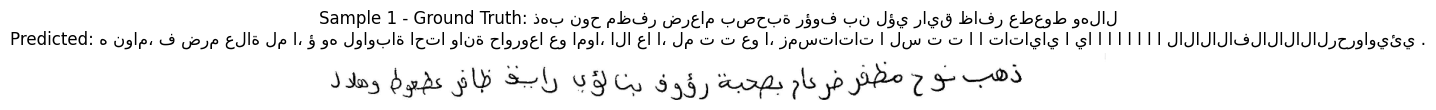

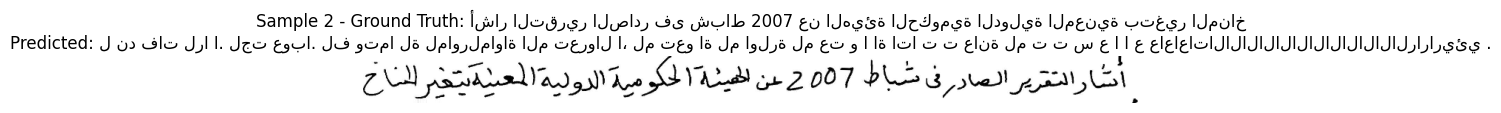

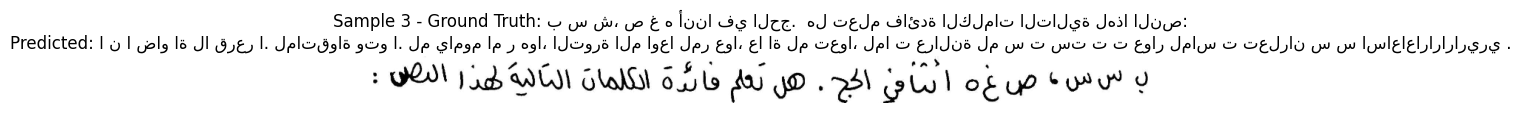

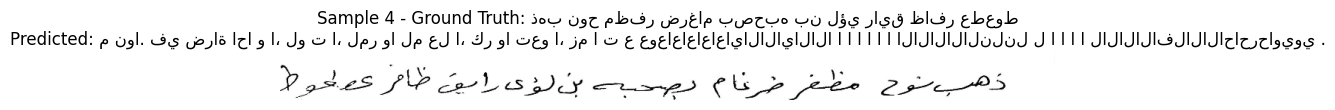

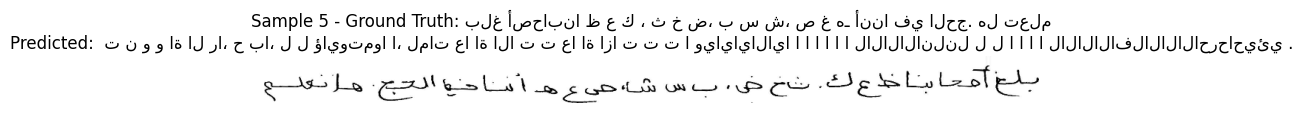

Test Loss: 23006.818359375
Test CER: 2.0787
Test WER: 10.1985


In [61]:
## WORKS PERFECTLY FINE

def evaluate_test_set(model, test_generator, num_to_char, char_to_num, blank_token='~', visualize=False, num_samples=5):
    """
    Evaluates the model on the test set to compute test loss, CER, and WER.
    Optionally visualizes a few decoded samples.

    Args:
        model (tf.keras.Model): The trained OCR model.
        test_generator (OCRDataGenerator): The test data generator.
        num_to_char (dict): Mapping from numerical indices to characters.
        char_to_num (dict): Mapping from characters to numerical indices.
        blank_token (str): The token used for padding/blanks.
        visualize (bool): Whether to visualize decoded samples.
        num_samples (int): Number of samples to visualize.

    Returns:
        tuple: (test_loss, cer, wer)
    """

    # Access the image input tensor
    image_input = None
    for inp in model.inputs:
        if 'image_input' in inp.name:
            image_input = inp
            break
    if image_input is None:
        raise ValueError("Could not find the image_input tensor in the model inputs.")

    # Access the logits output tensor
    logits_output = model.get_layer('logits').output

    # Create the prediction model
    prediction_model = Model(inputs=image_input, outputs=logits_output)

    all_preds = []
    all_labels = []
    visual_samples = []

    # Iterate over the test generator
    for i in range(len(test_generator)):
        inputs, _ = test_generator[i]
        # Get logits
        logits = prediction_model.predict(inputs['image_input'])
        # Decode predictions
        decoded_preds = decode_predictions(logits, inputs['input_length'], num_to_char)
        # Get ground truth labels
        decoded_labels = decode_labels(inputs['label_input'], num_to_char, blank_token)

        all_preds.extend(decoded_preds)
        all_labels.extend(decoded_labels)

        # Collect samples for visualization
        if visualize and len(visual_samples) < num_samples:
            for j in range(len(decoded_preds)):
                if len(visual_samples) >= num_samples:
                    break
                img = inputs['image_input'][j].squeeze()
                gt_label = decoded_labels[j]
                pred_label = decoded_preds[j]
                visual_samples.append((img, gt_label, pred_label))

    # Compute CER and WER
    cer = calculate_cer(all_labels, all_preds)
    wer = calculate_wer(all_labels, all_preds)

    # Compute test loss
    test_loss = model.evaluate(
        test_generator,
        steps=len(test_generator),
        verbose=1
    )

    # Visualization
    if visualize:
        for idx, (img, gt_label, pred_label) in enumerate(visual_samples):
            # Flip the image back to original RTL orientation
            img_flipped = np.fliplr(img)  # Assuming 'img' is a NumPy array

            plt.figure(figsize=(10, 2))
            plt.imshow(img_flipped, cmap='gray')
            plt.title(f"Sample {idx+1} - Ground Truth: {gt_label}\nPredicted: {pred_label}")
            plt.axis('off')
            plt.show()
            plt.close()

    return test_loss, cer, wer

def decode_predictions(logits, input_lengths, num_to_char):
    """
    Decodes the logits to text labels using beam search decoding.

    Args:
        logits (np.ndarray): The model's output logits.
        input_lengths (np.ndarray): The sequence lengths for each sample.
        num_to_char (dict): Mapping from numerical indices to characters.

    Returns:
        list: Decoded text labels.
    """
    # Transpose logits to shape [max_time, batch_size, num_classes]
    logits = np.transpose(logits, (1, 0, 2))
    
    batch_size = logits.shape[1]
    max_time = logits.shape[0]
    
    # Convert input_lengths to a 1D array
    sequence_length = input_lengths.flatten().astype(np.int32)
    
    # Use TensorFlow's CTC beam search decoder
    decoded, _ = tf.nn.ctc_beam_search_decoder(
        inputs=logits,
        sequence_length=sequence_length,
        beam_width=10,
        top_paths=1
    )

    # Convert sparse tensor to dense
    dense_decoded = tf.sparse.to_dense(decoded[0], default_value=-1).numpy()

    # Convert numerical indices to characters, ignoring padding (-1)
    decoded_labels = []
    for seq in dense_decoded:
        text = ''.join([num_to_char.get(idx, '') for idx in seq if idx != -1])
        text = text[::-1]  # Reverse to match original RTL orientation
        decoded_labels.append(text)

    return decoded_labels

def decode_labels(labels, num_to_char, blank_token='~'):
    """
    Decodes the ground truth labels from integer indices to text.

    Args:
        labels (np.ndarray): Ground truth labels.
        num_to_char (dict): Mapping from numerical indices to characters.
        blank_token (str): The token used for padding/blanks.

    Returns:
        list: Decoded text labels.
    """
    decoded_labels = []
    blank_index = char_to_num[blank_token]
    for label in labels:
        # Remove padding (blank_token)
        label = label[label != blank_index]
        text = ''.join([num_to_char.get(idx, '') for idx in label])
        # Reverse the text to correct orientation
        text = text[::-1]
        decoded_labels.append(text)
    return decoded_labels

def levenshtein_distance(s1, s2):
    """
    Computes the Levenshtein distance between two strings.

    Args:
        s1 (str): First string.
        s2 (str): Second string.

    Returns:
        int: Levenshtein distance.
    """
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    # len(s1) >= len(s2)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1  # Insertion
            deletions = current_row[j] + 1        # Deletion
            substitutions = previous_row[j] + (c1 != c2)  # Substitution
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]

def calculate_cer(ground_truth, predictions):
    """
    Calculates the Character Error Rate (CER).

    Args:
        ground_truth (list): List of ground truth text labels.
        predictions (list): List of predicted text labels.

    Returns:
        float: CER value.
    """
    total_chars = 0
    total_errors = 0
    for gt, pred in zip(ground_truth, predictions):
        total_chars += len(gt)
        total_errors += levenshtein_distance(gt, pred)
    return total_errors / total_chars if total_chars > 0 else 0.0

def calculate_wer(ground_truth, predictions):
    """
    Calculates the Word Error Rate (WER).

    Args:
        ground_truth (list): List of ground truth text labels.
        predictions (list): List of predicted text labels.

    Returns:
        float: WER value.
    """
    total_words = 0
    total_errors = 0
    for gt, pred in zip(ground_truth, predictions):
        gt_words = gt.split()
        pred_words = pred.split()
        total_words += len(gt_words)
        total_errors += levenshtein_distance(' '.join(gt_words), ' '.join(pred_words))
    return total_errors / total_words if total_words > 0 else 0.0
    
# Assuming you have a trained model and test_generator is properly set up
test_loss, test_cer, test_wer = evaluate_test_set(
    model=model,
    test_generator=test_generator,
    num_to_char=num_to_char,
    char_to_num=char_to_num,
    blank_token='~',  # Replace with your actual blank token
    visualize=True,
    num_samples=5
)

print(f"Test Loss: {test_loss}")
print(f"Test CER: {test_cer:.4f}")
print(f"Test WER: {test_wer:.4f}")

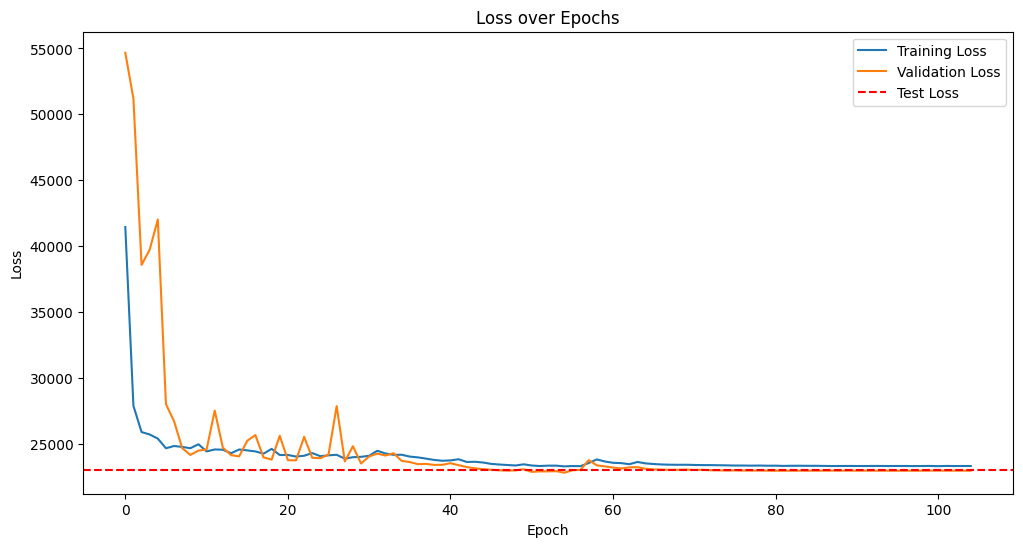

In [62]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add test loss as a horizontal line
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')

plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'OCR_loss_{SEED}.png')
plt.show()
plt.close()

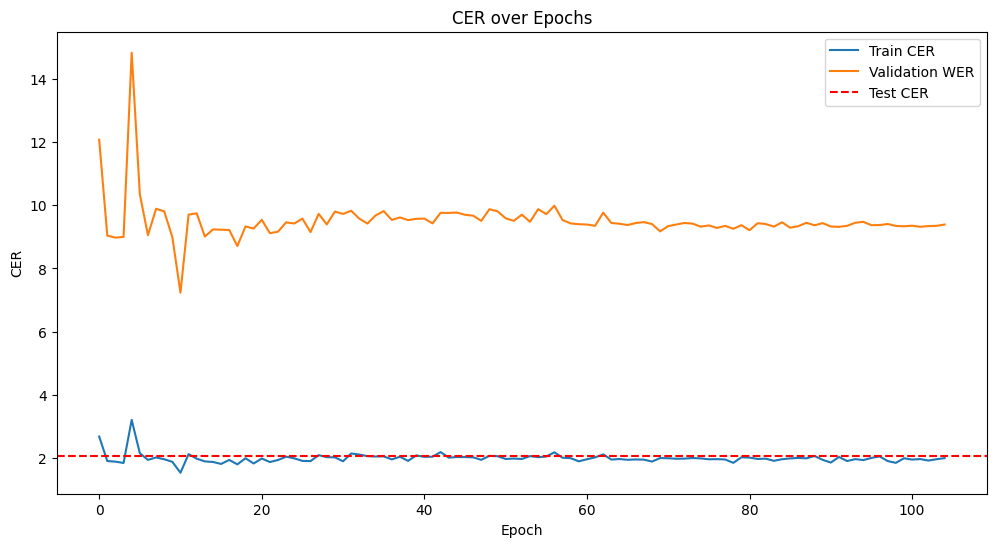

In [63]:
# Plot training and validation CER
plt.figure(figsize=(12, 6))
plt.plot(history.history['train_cer'], label='Train CER')
plt.plot(history.history['val_wer'], label='Validation WER')

# Add test cer as a horizontal line
plt.axhline(y=test_cer, color='r', linestyle='--', label='Test CER')

plt.title('CER over Epochs')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.legend()
plt.savefig(f'OCR_CER_{SEED}.png')
plt.show()
plt.close()

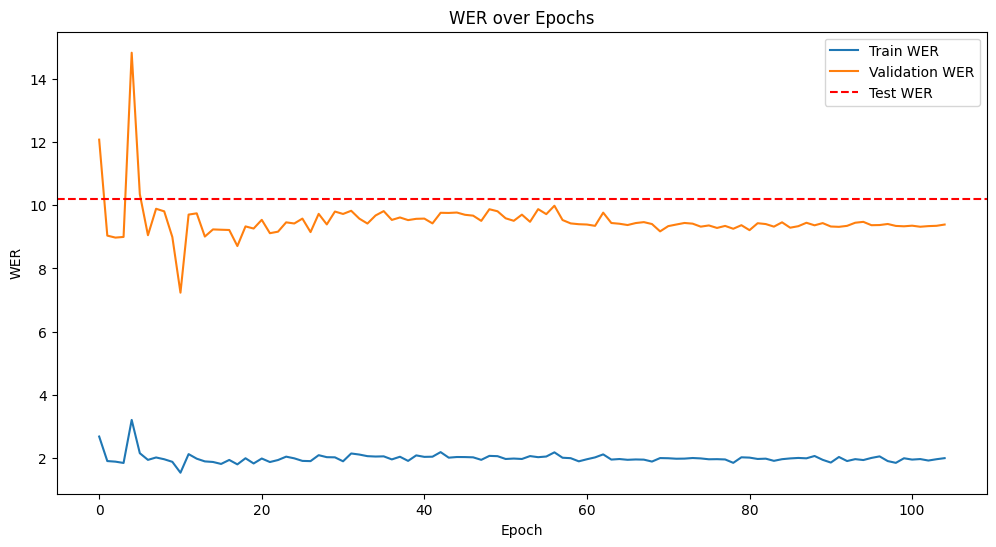

In [64]:
# Plot training and validation WER
plt.figure(figsize=(12, 6))
plt.plot(history.history['train_cer'], label='Train WER')
plt.plot(history.history['val_wer'], label='Validation WER')

# Add test wer as a horizontal line
plt.axhline(y=test_wer, color='r', linestyle='--', label='Test WER')

plt.title('WER over Epochs')
plt.xlabel('Epoch')
plt.ylabel('WER')
plt.legend()
plt.savefig(f'OCR_WER_{SEED}.png')
plt.show()
plt.close()

In [65]:
# Save the history.history dictionary to a file
with open(f'OCR_history_seed_{SEED}.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Save the evaluation metrics to a JSON file, including top-5 accuracy
test_metrics = {
    'test_loss': test_loss,
    'test_cer': test_cer,
    'test_wer': test_wer,
}
with open(f'OCR_test_metrics_seed_{SEED}.json', 'w') as f:
    json.dump(test_metrics, f)

# Save the elapsed time to a file
with open(f'OCR_elapsed_time_seed_{SEED}.txt', 'w') as f:
    f.write(str(elapsed_time))

In [66]:
### LOADING WORRKSSS

In [67]:
from tensorflow.keras.utils import get_custom_objects

# Register all custom layers globally
get_custom_objects().update({
    'CTCLossLayer': CTCLossLayer,
    # 'ctc_dummy_loss': ctc_dummy_loss,
})

In [68]:
model.save(f"ocr_model_with_ctc_last_model_{SEED}.keras")

In [69]:
# Ensure the custom objects are registered
loaded_model = tf.keras.models.load_model(f"ocr_model_with_ctc_last_model_{SEED}.keras", custom_objects={
    'CTCLossLayer': CTCLossLayer,
    # 'ctc_dummy_loss': ctc_dummy_loss,
})

loaded_model.summary()

Model: "OCR_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 64, 1048,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNet32            │ (None, 13, 64,    │ 11,090,816 │ image_input[0][0] │
│ (Functional)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_resnet      │ (None, 13, 64,    │          0 │ ResNet32[0][0]    │
│ (SpatialDropout2D)  │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 832, 256)  │          0 │ dropout_resnet[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 832, 1024) │  3,149,824 │ reshape[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 832, 1024) │  6,295,552 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 832, 1024) │  6,295,552 │ bidirectional_1[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_bilstm      │ (None, 832, 1024) │          0 │ bidirectional_2[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 832, 87)   │     89,175 │ dropout_bilstm[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss            │ (None, 832, 87)   │          0 │ label_input[0][0… │
│ (CTCLossLayer)      │                   │            │ logits[0][0],     │
│                     │                   │            │ input_length[0][… │
│                     │                   │            │ label_length[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 80,737,991 (307.99 MB)

 Trainable params: 26,908,535 (102.65 MB)

 Non-trainable params: 12,384 (48.38 KB)

 Optimizer params: 53,817,072 (205.30 MB)